In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import warnings
import pandas as pd
import networkx as nx
import math
import glob

# RDkit
import rdkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True # < use SVGs instead of PNGs
IPythonConsole.drawOptions.addAtomIndices = True # adding indices
IPythonConsole.molSize = 300, 300

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
import pydot

#tf.compat.v1.disable_eager_execution()

warnings.filterwarnings("ignore")

# logging
import logging 
logging.basicConfig(format='%(message)s')
log = logging.getLogger()
log.setLevel(logging.INFO)

2024-09-11 17:04:59.939232: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-11 17:05:00.005300: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-11 17:05:04.300751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
def make_adjacency_matrix(adjacency_mat: np.ndarray, edges: list, map_indexes: dict = None):
    """
    Function to make the adjacency matrix
    :params adjacency_mat: numpy array - blank numpy array of n nodes sqaure
    :params edges: iterable - iterable of paris of nodes to defined edges these 
                              will be sorted and indexed based on the sorted iterable
    :return adjacency_mat: numpy array
    """
    
    log = logging.getLogger(__name__)
    
    if map_indexes is not None:
        for ith, edg in enumerate(edges):
            edges[ith] = (map_indexes[edg[0]], map_indexes[edg[1]])
    
    for i, j in edges:
        log.debug(f"updating {i}, {j}")
        adjacency_mat[i, j] = 1
        
    return adjacency_mat
        
def symmeterize_edges(edges: list):
    """
    Function to make a symmetric set from an asymmetric set of edges
    :param edges: list - list of edges
    :return list - symmetric edges
    """
    
    log = logging.getLogger(__name__)
    
    new_edges = []
    for e in edges:
        log.debug(f"updating {e[1]}, {e[0]}")
        new_edges.append((e[0], e[1]))
        new_edges.append((e[1], e[0]))
        
    new_edges = sorted(list(set(new_edges)))
    
    return new_edges

def adjacency_matrix(nodes: list, edges: list, symmetric: bool = None, self_connection: bool = False):
    """
    Function to build an adjacency matrix from iterables of nodes and edges.
    :param nodes: iterable - iterable of nodes these will be sorted 
                             and indexed based on the sorted iterable
    :params edges: iterable - iterable of paris of nodes to defined edges these 
                              will be sorted and indexed based on the sorted iterable
    :params symmetric: bool - (optional) None has no effect, True nodes have been input as 
                              directed without symmetric actions but the adjacency 
                              martix needs to be symmeterized, False use a 
                              unsymmetrerized adjacency
    :params self_connection: bool - (optional) False nodes are not self connected unless explicitly given 
                                     True make all nodes self connected
    :return matrix: np.array - adjacency matrix 
    """
    
    log = logging.getLogger(__name__)
    
    n_nodes = len(nodes)
    adjacency_mat = np.zeros((n_nodes, n_nodes))
    
    log.debug(adjacency_mat)
    
    node_idxs = {n: ith for ith, n in enumerate(sorted(nodes))}
    
    if symmetric is True:
        edges = symmeterize_edges(edges)
    edge_idxs = {e: ith for ith, e in enumerate(edges)}        
    
    adjacency_mat = make_adjacency_matrix(adjacency_mat, edges, map_indexes=node_idxs)
    
    if self_connection is True:
        adjacency_mat = adjacency_mat + np.eye(n_nodes, n_nodes)
    
    log.info(adjacency_mat)
    
    return adjacency_mat
    
def electronegativity(element_label, return_dict=False, nan_swap=np.nan):
    """
    Pauling electronegativity from Inorganic Chemistry Principles of Structure and Reactivity second Ed. James E. Huheey
    pp162:164 Table 4.8 Electronegativities of the elements. Oxidation states are inculded for
    some elements in (roman numerals) such as Fe(III)
    :param element_label: str - element label as as string
    :param return_dict: bool - return the electronegativity dictionary rather than a value
    :param nan_sub: numeric - a numeric value to subsitute np.nan with. np.nan signifies the electronegativity 
                              is uknown or unmeasurable
    :return: float or dictionary
    >>> atomic_electronegativity("H")
    2.2
    """

    log = logging.getLogger(__name__)

    electneg = {}
    electneg["H"] = 2.2
    electneg["He"] = np.nan
    electneg["Li"] = 0.98
    electneg["Be"] = 1.57
    electneg["B"] = 2.04
    electneg["C"] = 2.55
    electneg["N"] = 3.04
    electneg["O"] = 3.44
    electneg["F"] = 3.98
    electneg["Ne"] = np.nan
    electneg["Na"] = 0.93
    electneg["Mg"] = 1.31
    electneg["Al"] = 1.61
    electneg["Si"] = 1.9
    electneg["P"] = 2.19
    electneg["S"] = 2.58
    electneg["Cl"] = 3.16
    electneg["Ar"] = np.nan
    electneg["K"] = 0.82
    electneg["Ca"] = 1
    electneg["Sc"] = 1.36
    electneg["Ti"] = 1.54
    electneg["Ti(II)"] = 1.54
    electneg["V"] = 1.63
    electneg["V(II)"] = 1.563
    electneg["Cr"] = 1.66
    electneg["Cr(II)"] = 1.66
    electneg["Mn"] = 1.55
    electneg["Mn(II)"] = 1.55
    electneg["Fe"] = 1.83
    electneg["Fe(II)"] = 1.83
    electneg["Fe(III)"] = 1.96
    electneg["Co"] = 1.88
    electneg["Co(II)"] = 1.88
    electneg["Ni"] = 1.91
    electneg["Ni(II)"] = 1.91
    electneg["Cu"] = 1.9
    electneg["Cu(I)"] = 1.9
    electneg["Cu(II)"] = 2
    electneg["Zn"] = 1.65
    electneg["Zn(II)"] = 1.65
    electneg["Ga"] = 1.81
    electneg["Ga(III)"] = 1.81
    electneg["Ge"] = 2.01
    electneg["Ge(IV)"] = 2.01
    electneg["As"] = 2.18
    electneg["As(III)"] = 2.18
    electneg["Se"] = 2.55
    electneg["Br"] = 2.96
    electneg["Kr"] = 2.9
    electneg["Rb"] = 0.82
    electneg["Sr"] = 0.95
    electneg["Y"] = 1.22
    electneg["Zr"] = 1.33
    electneg["Zr(II)"] = 1.33
    electneg["Nb"] = 1.6
    electneg["Mo"] = 2.16
    electneg["Mo(II)"] = 2.16
    electneg["Mo(III)"] = 2.19
    electneg["Mo(IV)"] = 2.24
    electneg["Mo(V)"] = 2.27
    electneg["Mo(VI)"] = 2.35
    electneg["Tc"] = 1.9
    electneg["Ru"] = 2.2
    electneg["Rh"] = 2.28
    electneg["Pd"] = 2.2
    electneg["Ag"] = 1.93
    electneg["Cd"] = 1.69
    electneg["In"] = 1.78
    electneg["Sn"] = 1.96
    electneg["Sn(II)"] = 1.8
    electneg["Sn(IV)"] = 1.96
    electneg["Sb"] = 2.05
    electneg["Te"] = 2.1
    electneg["I"] = 2.66
    electneg["Xe"] = 2.6
    electneg["Cs"] = 0.79
    electneg["Ba"] = 0.89
    electneg["La"] = 1.1
    electneg["Ce"] = 1.12
    electneg["Pr"] = 1.13
    electneg["Nd"] = 1.14
    electneg["Pm"] = np.nan
    electneg["Sm"] = 1.17
    electneg["Eu"] = np.nan
    electneg["Gd"] = 1.2
    electneg["Tb"] = np.nan
    electneg["Dy"] = 1.22
    electneg["Ho"] = 1.23
    electneg["Er"] = 1.24
    electneg["Tm"] = 1.25
    electneg["Yb"] = np.nan
    electneg["Lu"] = 1.27
    electneg["Hf"] = 1.3
    electneg["Ta"] = 1.5
    electneg["W"] = 2.36
    electneg["Re"] = 1.9
    electneg["Os"] = 2.2
    electneg["Ir"] = 2.2
    electneg["Pt"] = 2.28
    electneg["Au"] = 2.54
    electneg["Hg"] = 2
    electneg["Tl"] = 1.62
    electneg["Tl(I)"] = 1.62
    electneg["Tl(III)"] = 2.04
    electneg["Pb"] = 2.33
    electneg["Pb(II)"] = 1.87
    electneg["Pb(IV)"] = 2.33
    electneg["Bi"] = 2.02
    electneg["Po"] = 2
    electneg["At"] = 2.2
    electneg["Rn"] = np.nan
    electneg["Fr"] = 0.7
    electneg["Ra"] = 0.9
    electneg["Ac"] = 1.1
    electneg["Th"] = 1.3
    electneg["Pa"] = 1.5
    electneg["U"] = 1.7
    electneg["Np"] = 1.3
    electneg["Pu"] = 1.3
    electneg["Am"] = 1.3
    electneg["Cm"] = 1.3
    electneg["Bk"] = 1.3
    electneg["Cf"] = 1.3
    electneg["Es"] = 1.3
    electneg["Fm"] = 1.3
    electneg["Md"] = 1.3
    electneg["No"] = 1.3
    electneg["Lr"] = np.nan
    electneg["Rf"] = np.nan
    electneg["Db"] = np.nan
    electneg["Sg"] = np.nan
    electneg["Bh"] = np.nan
    electneg["Hs"] = np.nan
    electneg["Mt"] = np.nan
    electneg["Ds"] = np.nan
    electneg["Rg"] = np.nan
    electneg["Cn"] = np.nan
    electneg["Nh"] = np.nan
    electneg["Fl"] = np.nan
    electneg["Mc"] = np.nan
    electneg["Lv"] = np.nan
    electneg["Ts"] = np.nan
    electneg["Og"] = np.nan

    electneg = {k.lower(): v for k, v in electneg.items()}

    if not np.isnan(nan_swap):
        electneg = {(k if not np.isnan(v) else k) : (v if not np.isnan(v) else nan_swap) for k, v in electneg.items()}

    if return_dict is True:
        return electneg
    elif element_label.lower() in electneg.keys():
        return electneg[element_label.lower()]
    else:
        log.error("Error no electronegativity for element label {}".format(element_label))
        raise RuntimeError

def get_atomic_number(atom):
    """
    """
    
    return atom.GetAtomicNum()

def get_electronegativity(atom):
    """
    """
    
    return electronegativity(atom.GetSymbol())

def bond_type_encoder(bondtype: str = None, return_dict: bool = False):
    """
    Return a unique integer encoding for all bond types RDKit can recognize
    :param bondtype: str - string defining the bond type from RDkit (bond.GetBondType())
    :return int
    """
    encoder = {}
    encoder[None] = 0
    encoder["SINGLE"] = 1
    encoder["DOUBLE"] = 2
    encoder["TRIPLE"] = 3
    encoder["QUADRUPLE"] = 4
    encoder["QUINTUPLE"] = 5
    encoder["HEXTUPLE"] = 6
    encoder["ONEANDAHALF"] = 7
    encoder["TWOANDAHALF"] = 8
    encoder["THREEANDAHALF"] = 9
    encoder["FOURANDAHALF"] = 10
    encoder["FIVEANDAHALF"] = 11
    encoder["AROMATIC"] = 12
    encoder["IONIC"] = 13
    encoder["HYDROGEN"] = 14
    encoder["THREECENTER"] = 15
    encoder["DATIVEONE"] = 16
    encoder["DATIVE"] = 17
    encoder["DATIVEL"] = 18
    encoder["DATIVER"] = 19
    encoder["OTHER"] = 20
    encoder["ZERO"] = 21
    encoder["UNSPECIFIED"] = 22
    
            
    if return_dict is False:
        return encoder[bondtype.upper()]
    elif return_dict is True:
        return encoder

def get_bond_type(bond):
    """
    """
    
    return bond_type_encoder(str(bond.GetBondType()))


class NodeFeatures(object):
    """
    Class to store and generate node features
    """
    
    def __init__(self, add_feature_functions: list = [get_atomic_number], use_default_feature: bool = True):
        """
        Initialize the class here
        """
        
        self.feature_functions = add_feature_functions
        
    def add_feature_function(self, feature_function):
        """
        Function to add a feature function to the class 
        the feature function should take only an RDKit 
        atom as its arguments
        """
        
        self.feature_functions.append(feature_function)
        self.feature_functions = self.feature_functions
        
    def get_feture_functions(self):
        """
        Function to return the current set of feature functions
        """
        
        return self.feature_functions
        
    def calculate_features(self, atom):
        """
        Function to calculate the features
        """
        
        output = []
        
        for feat in self.feature_functions:
            output.append(feat(atom))
            
        return output
    
    def get_feature_tensor(self, mol: rdkit.Chem.rdchem.Mol):
        """
        Function to take a molecules are return the node part of the graph as a tensor
        """
        
        feature_order = [str(f).split()[1] for f in self.get_feture_functions()]
        node_tensor = np.zeros((mol.GetNumAtoms(), len(self.feature_functions)))
        
        for atom in mol.GetAtoms():
            v = self.calculate_features(atom)
            for ith in range(len(self.feature_functions)):
                node_tensor[atom.GetIdx()][ith] = v[ith]
        
        return node_tensor, feature_order
        
        
class EdgeFeatures(object):
    """
    Class to store and generate edge features
    """
    
    def __init__(self, add_feature_functions: list = [get_bond_type], use_default_feature: bool = True):
        """
        Initialize the class here
        """
        
        self.feature_functions = add_feature_functions
        
    def add_feature_function(self, feature_function):
        """
        Function to add a feature function to the class 
        the feature function should take only an RDKit 
        atom as its arguments
        """
        
        self.feature_functions.append(feature_function)
        self.feature_functions = self.feature_functions
        
    def get_feture_functions(self):
        """
        Function to return the current set of feature functions
        """
        
        return self.feature_functions
        
    def calculate_features(self, bond):
        """
        Function to calculate the features
        """
        
        output = []
        
        for feat in self.feature_functions:
            output.append(feat(bond))
            
        return output
    
    def get_adjacency_matrix(self, mol: rdkit.Chem.rdchem.Mol, use_bond_order=False, self_connection=False):
        """
        Function to get a molecule adjacency matrix
        """
        
        mat = GetAdjacencyMatrix(mol, useBO=use_bond_order)
        
        if self_connection is True:
            mat = mat + np.eye(mol.GetNumAtoms(), mol.GetNumAtoms())
            
        return mat
        
    
    def get_feature_tensor(self, mol: rdkit.Chem.rdchem.Mol, symmetric=True, verbose=False):
        """
        Function to take a molecule then return the edge part of the graph as a tensor
        """
        
        feature_order = [str(f).split()[1] for f in self.get_feture_functions()]
        edge_tensor = np.zeros((mol.GetNumAtoms(), mol.GetNumAtoms(), len(self.feature_functions)))
        
        if symmetric is True:
            for bond in mol.GetBonds():
                x = min(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
                y = max(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
                v = self.calculate_features(bond)
                for ith in range(len(self.feature_functions)):
                    edge_tensor[x, y, ith] = v[ith]
                    edge_tensor[y, x, ith] = v[ith]
                    if verbose is True:
                        log.info("edge_tensor[{0}, {1}, {2}] = {3}\n"
                              "edge_tensor[{1}, {0}, {2}] = {3}".format(x, y ,ith, v[ith]))
        elif symmetric is False:
            for bond in mol.GetBonds():
                x = min(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
                y = max(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
                v = self.calculate_features(bond)
                for ith in range(len(self.feature_functions)):
                    edge_tensor[x, y, ith] = v[ith]
                    if verbose is True:
                        log.info("edge_tensor[{0}, {1}, {2}] = {3}\n"
                        "edge_tensor[{1}, {0}, {2}] = {4}".format(x, y ,ith, v[ith], edge_tensor[y, x, ith]))
        else:
            log.warning("WARNING - symmetric must be set to 1 or 0")
            return None, None
        
        return edge_tensor, feature_order

In [11]:
modelname = 'validation'
formulation_file = "/u/murtazaz/ionic_cond/082324/train_combdata_082324.csv"
# data = pd.read_excel(formulation_file)
data = pd.read_csv(formulation_file)
data.columns = [ent.strip() for ent in data.columns]
data = data.iloc[0:500]


property_columns = ["log(cond) (uS/cm)"]
max_atomic_number_to_represent = 118
n_node_features = 100
n_node_features = int(n_node_features)

formulations_smiles_columns = ["smiles1", "smiles2", "smiles3", "smiles4","smiles5","smiles6"]
assert all(ent in data.columns for ent in formulations_smiles_columns), "ERROR - formulation smiles column header not found in data"

formulations_concer_columns = ["conc1", "conc2", "conc3", "conc4","conc5","conc6"]
assert all(ent in data.columns for ent in formulations_concer_columns), "ERROR - formulation concerntration column header not found in data"

cathode_loading_columns = ["temperature ( C )"]

n_formaulatants = len(formulations_smiles_columns)
n_conc = len(formulations_concer_columns)
assert n_formaulatants == n_conc, "ERROR - the number of molecules in the formulation and the number of concerntration do not match"

formulation_indx = [ith for ith in range(len(data.index))]

log.info("Training network for {} formulants over {} examples".format(n_formaulatants, len(formulation_indx)))

Training network for 6 formulants over 500 examples


In [12]:
def bond_type_encoder(bondtype: str = None, return_dict: bool = False):
    """
    Return a unique integer encoding for all bond types RDKit can recognize
    :param bondtype: str - string defining the bond type from RDkit (bond.GetBondType())
    :return int
    """
    encoder = {}
    encoder[None] = 0
    encoder["SINGLE"] = 1
    encoder["DOUBLE"] = 2
    encoder["TRIPLE"] = 3
    encoder["QUADRUPLE"] = 4
    encoder["QUINTUPLE"] = 5
    encoder["HEXTUPLE"] = 6
    encoder["ONEANDAHALF"] = 7
    encoder["TWOANDAHALF"] = 8
    encoder["THREEANDAHALF"] = 9
    encoder["FOURANDAHALF"] = 10
    encoder["FIVEANDAHALF"] = 11
    encoder["AROMATIC"] = 12
    encoder["IONIC"] = 13
    encoder["HYDROGEN"] = 14
    encoder["THREECENTER"] = 15
    encoder["DATIVEONE"] = 16
    encoder["DATIVE"] = 17
    encoder["DATIVEL"] = 18
    encoder["DATIVER"] = 19
    encoder["OTHER"] = 20
    encoder["ZERO"] = 21
    encoder["UNSPECIFIED"] = 22
    
            
    if return_dict is False:
        return encoder[bondtype.upper()]
    elif return_dict is True:
        return encoder

def get_adjacency_matrix(mol: rdkit.Chem.rdchem.Mol, use_bond_order=False, self_connection=False):
    """
    Function to get a molecule adjacency matrix
    """

    mat = GetAdjacencyMatrix(mol, useBO=use_bond_order)

    if self_connection is True:
        mat = mat + np.eye(mol.GetNumAtoms(), mol.GetNumAtoms())

    return mat
    
def smiles_to_graph_input(data, smiles_cols, conc_cols, prop_cols, n_formaulatants, loading, n_node_features= 100, max_atomic_number_to_represent=118):
    """
    Function to output N graphs and N properties for a given input formulation.
    The formulation data should be in a csv file (or equivalent) read by pandas.
    The read in data is given to the data variable. The column headers for the smiles, concerntrations
    and properties are given reprectively to smiles_cols, conc_cols, prop_cols as lists. The number
    of molecules in a formaulation needs to be consistent (for now) n_formaulatants is a integer tah tdefine this
    :param data: pandas.Series - a row from a read file as a dataframe of formulations to run over
    :param smiles_cols: list - list of columns which contain the smiles strings for each component of the formulation
    :param conc_cols: list - list of columns which contain the concerntration floats for each component of the formulation
    :param prop_cols: list - list of columns which contain the properties to predict for each formulation
    :param n_formaulatants: int - number of molecule components in each formulation needs to be the same for all
    :param max_atomic_number_to_represent: int - the highest atomic number to encode for a node
    :return tuple nodesX (0 -> n_formaulatants), adjacency matrixX (0 -> n_formaulatants), concerntrations
    """
    # Get the concerntrations from the series and set them to be a numpy array 
    wt = data[conc_cols].astype(float).to_numpy()
    cath = data[loading].astype(float).to_numpy()
    wt = wt/100
    # Get the smiles as a numpy array
    smiles = np.array([ent.strip() for ent in data[smiles_cols].astype(str)])
    
    graphs = [] # Note the order is important nodes0, adjacency matrix0, nodes1, adjacencey matrix1 .....
    
    # Dictionary to encode all RDKit bond types
    bond_encoder = bond_type_encoder(return_dict=True)
    
    # Make the graphs
    for ith, smile in enumerate(smiles):
        mol = Chem.MolFromSmiles(smile, sanitize=False)
        mol.UpdatePropertyCache(strict=False)
        mol = Chem.AddHs(mol)
         
    
        
        n_atoms = mol.GetNumAtoms()
        
        # Assume max elements to consider is 118 make a blank numpy array to encode which element are present in the molecule
        node = np.zeros((n_atoms, n_node_features))
        for atom in mol.GetAtoms():
            node[atom.GetIdx(), atom.GetAtomicNum()-1] = electronegativity(atom.GetSymbol(), nan_swap=0.0)
            
        graphs.append(node)
        
        # Get the adjacency matrix
        adjacency_matrix = get_adjacency_matrix(mol, use_bond_order=True, self_connection=True)
        
        graphs.append(adjacency_matrix)
        
    
    node0, adj0, node1, adj1, node2, adj2, node3, adj3, node4, adj4, node5, adj5 = graphs
    return node0, adj0, node1, adj1, node2, adj2, node3, adj3, node4, adj4, node5, adj5, wt, cath


In [13]:
class GCNLayer(tf.keras.layers.Layer):
    """Implementation of GCN as layer"""

    def __init__(self, activation=None, **kwargs):
        # constructor, which just calls super constructor
        # and turns requested activation into a callable function
        super(GCNLayer, self).__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # create trainable weights
        node_shape, adj_shape = input_shape
        self.w = self.add_weight(shape=(node_shape[2], node_shape[2]), name="w")

    def call(self, inputs):
        # split input into nodes, adj
        nodes, adj = inputs
        # compute degree
        
        degree = tf.reduce_sum(adj, axis=-1)
        # GCN equation
        # degree[b,i] * adj[b, i, j] * nodes[b, j, k] * weights[k, l]
        new_nodes = tf.einsum("bi,bij,bjk,kl->bil", 1 / degree, adj, nodes, self.w)
        out = self.activation(new_nodes)
        return out, adj

class GRLayer(tf.keras.layers.Layer):
    """A GNN layer that computes average over all node features"""

    def __init__(self, name="GRLayer", **kwargs):
        super(GRLayer, self).__init__(name=name, **kwargs)

    def call(self, inputs):
        nodes, adj = inputs
        reduction = tf.reduce_mean(nodes, axis=1)
        return reduction
    
def gcn_mols(n_node_features):
    
    ninput = tf.keras.Input((None,n_node_features,))
    ainput = tf.keras.Input((None,None,))
    
    
    layer1 = GCNLayer("tanh")([ninput, ainput])
    layer2 = GCNLayer("tanh")(layer1)
    layer3 = GCNLayer("tanh")(layer2)
    layer4 = GCNLayer("tanh")(layer3)
    # reduce to graph features
    layer5 = GRLayer()(layer4)
    # standard layers (the readout)
     #output = tf.keras.layers.Dense(10)(layer5)
    output = tf.keras.layers.Dense(1)(layer5)
    
    return keras.Model(inputs=(ninput, ainput), outputs=layer5)

def gen_graphs_and_labels(data, formulations_smiles_columns, formulations_concer_columns, property_columns, n_formaulatants, cathode_loading_columns):
    cols = formulations_smiles_columns + formulations_concer_columns + property_columns + cathode_loading_columns
    for i in data.index:
        graphs = smiles_to_graph_input(data.loc[i, cols], formulations_smiles_columns, formulations_concer_columns, property_columns, n_formaulatants, cathode_loading_columns)
        label = data.loc[i, property_columns].astype(float).to_numpy()
        yield graphs, label

In [14]:
output_signature_list = []

for i in range(n_formaulatants):
    output_signature_list.append(tf.TensorSpec(shape=(None, n_node_features),  dtype=tf.float32))
    output_signature_list.append(tf.TensorSpec(shape=(None, None),  dtype=tf.float32))
    
output_signature_list = output_signature_list + [tf.TensorSpec(shape=(n_formaulatants,), dtype=tf.float32)]+ [tf.TensorSpec(shape=(1,), dtype=tf.float32)] 

log.info("\nOutput shapes\n{}".format(output_signature_list))


Output shapes
[TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None)]


In [15]:
dataset = tf.data.Dataset.from_generator(
    lambda: gen_graphs_and_labels(data, formulations_smiles_columns, formulations_concer_columns, property_columns, n_formaulatants, cathode_loading_columns),
    output_signature=(tuple(output_signature_list), (tf.TensorSpec(shape=(1,),  dtype=tf.float32))
                 ),
)
                      

log.info(f"data set {dataset}")

data set <_FlatMapDataset element_spec=((TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None)), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>


In [16]:
formulation_file = r"test_combdata_082324.csv"
val_csv = pd.read_csv(formulation_file)
val_csv.columns = [ent.strip() for ent in val_csv.columns]
val_data = val_csv.sample(frac=0.2)

val_property_columns = ["log(cond) (uS/cm)"]

val_smiles_columns = ["smiles1", "smiles2", "smiles3", "smiles4","smiles5","smiles6"]
assert all(ent in val_data.columns for ent in val_smiles_columns), "ERROR - formulation smiles column header not found in data"

val_concer_columns = ["conc1", "conc2", "conc3", "conc4","conc5","conc6"]
assert all(ent in val_data.columns for ent in val_concer_columns), "ERROR - formulation concerntration column header not found in data"

val_cathode_loading_columns = ["temperature ( C )"]

val_formaulatants = len(val_smiles_columns)
val_conc = len(val_concer_columns)
assert val_formaulatants == val_conc, "ERROR - the number of molecules in the formulation and the number of concerntration do not match"

val_formulation_indx = [ith for ith in range(len(val_data.index))]


val_output_signature_list = []

for i in range(val_formaulatants):
    val_output_signature_list.append(tf.TensorSpec(shape=(None, n_node_features),  dtype=tf.float32))
    val_output_signature_list.append(tf.TensorSpec(shape=(None, None),  dtype=tf.float32))
    
val_output_signature_list = val_output_signature_list + [tf.TensorSpec(shape=(val_formaulatants,), dtype=tf.float32)]+ [tf.TensorSpec(shape=(1,), dtype=tf.float32)] 

log.info("\nOutput shapes\n{}".format(val_output_signature_list))

val_dataset = tf.data.Dataset.from_generator(
    lambda: gen_graphs_and_labels(val_data, val_smiles_columns, val_concer_columns, val_property_columns, val_formaulatants, val_cathode_loading_columns),
    output_signature=(tuple(val_output_signature_list), (tf.TensorSpec(shape=(1,),  dtype=tf.float32))
                 ),
)
                      

# log.info(f"data set {val_dataset}")
val_dataset


Output shapes
[TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None)]


<_FlatMapDataset element_spec=((TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None)), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>

In [17]:
formulation_inputs = {}
model_molecule = {}
log.info(f"N node features {n_node_features}")
for i in range(n_formaulatants):
    formulation_inputs[f"node{i}"] = tf.keras.Input((None, n_node_features,),)
    
    formulation_inputs[f"adj{i}"]= tf.keras.Input((None, None,),)
    
    model_molecule[f"modelmolecule{i}"] = gcn_mols(n_node_features)
    model_molecule[f"modelmolecule{i}"].load_weights('./checkpointhlem/my_checkpoint')
    model_molecule[f"modelmolecule{i}"].trainable = False
    

wt = tf.keras.Input((None, None),)
cath = tf.keras.Input((1,),)

log.debug(f"\nformultion inps\n{formulation_inputs}\n")

log.debug(f"wt\n{wt}")
log.debug(f"wt\n{cath}")
gcn_out = {}
gcn_wt = {}
for i in range(n_formaulatants):
    #globals()['gcn_out%s'%i] = globals()['modelmolecule%s'%i]([globals()['node%s'%i], globals()['adj%s'%i]])
    #globals()['gcn_wt%s'%i] = layers.Multiply()([globals()['gcn_out%s'%i], wt[:,i]])
    
    gcn_out[f"gcn_out{i}"] = model_molecule[f'modelmolecule{i}']([formulation_inputs[f'node{i}'], formulation_inputs[f'adj{i}']])
    gcn_wt[f'gcn_wt{i}'] = layers.Multiply()([gcn_out[f'gcn_out{i}'], wt[:,i]])
    
    log.debug(f"\n{i} [gcn_out[f'gcn_out{i}'], wt[:,i]] = {[gcn_out[f'gcn_out{i}'], wt[:,i]]}\n")

log.debug(f"\ngcn out {gcn_out[f'gcn_out0']}\n")
log.debug(f"\ngcn wt {gcn_wt[f'gcn_wt0']}\n")
    
log.debug("\nLayers to add\n{}\n".format([v for _, v in gcn_wt.items()]))
x1 = layers.concatenate([v for _, v in gcn_wt.items()])
#x1 = layers.add([v for _, v in gcn_wt.items()])
#x = layers.Dense(10, activation='relu')(x)

#x2 = layers.Dense(1000, activation='relu')(x1)
x3 = layers.concatenate([x1, cath])
#x = layers.Dense(500, activation='relu')(x)
x = layers.Dense(200, activation='sigmoid')(x3)
x = layers.Dense(100, activation='sigmoid')(x)
#x = layers.Dense(100, activation='relu')(x)
performance = layers.Dense(1)(x)

inps = []
for ith in range(n_formaulatants):
    inps.append(formulation_inputs[f"node{ith}"])
    inps.append(formulation_inputs[f"adj{ith}"])

inps = inps +[wt] +[cath]
#tuple(inps)

log.debug(f"inps\n{inps}\n")

log.info(f"inputs {inps}\n")

electrolyte_model = keras.Model(inputs=inps, outputs=performance)
#electrolyte_model = keras.Model(inputs=[node0,adj0,node1,adj1,node2,adj2,node3,adj3,wt], outputs=capacity)

electrolyte_model.summary()

N node features 100


inputs [<KerasTensor: shape=(None, None, 100) dtype=float32 (created by layer 'input_27')>, <KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'input_28')>, <KerasTensor: shape=(None, None, 100) dtype=float32 (created by layer 'input_31')>, <KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'input_32')>, <KerasTensor: shape=(None, None, 100) dtype=float32 (created by layer 'input_35')>, <KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'input_36')>, <KerasTensor: shape=(None, None, 100) dtype=float32 (created by layer 'input_39')>, <KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'input_40')>, <KerasTensor: shape=(None, None, 100) dtype=float32 (created by layer 'input_43')>, <KerasTensor: shape=(None, None, None) dtype=float32 (created by layer 'input_44')>, <KerasTensor: shape=(None, None, 100) dtype=float32 (created by layer 'input_47')>, <KerasTensor: shape=(None, None, None) dtype=float32 (created b

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, None, 100)]          0         []                            
                                                                                                  
 input_28 (InputLayer)       [(None, None, None)]         0         []                            
                                                                                                  
 input_51 (InputLayer)       [(None, None, None)]         0         []                            
                                                                                                  
 input_31 (InputLayer)       [(None, None, 100)]          0         []                            
                                                                                           

In [18]:
opt= tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
electrolyte_model.compile(optimizer= opt, loss=tf.keras.losses.MeanSquaredError())


epochs = 2
save_period = 2
save_freq = int(epochs*len(formulation_indx)/save_period)
#save_freq = "epoch"

# Model Training
result = electrolyte_model.fit(
    dataset.batch(1), epochs=epochs, shuffle=True, verbose=2, validation_data = val_dataset.batch(1))
    # dataset.batch(1), epochs=epochs, shuffle=True, verbose=2)


electrolyte_model.save(modelname)

Epoch 1/2


500/500 - 33s - loss: 0.6689 - val_loss: 0.2455 - 33s/epoch - 65ms/step
Epoch 2/2
500/500 - 30s - loss: 0.2558 - val_loss: 0.2272 - 30s/epoch - 59ms/step
INFO:tensorflow:Assets written to: validation/assets


Assets written to: validation/assets


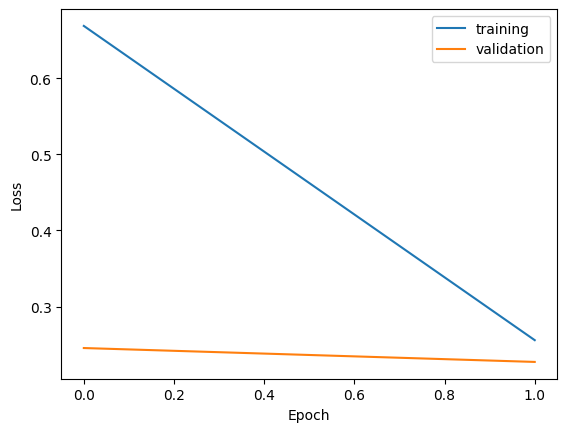

In [19]:
plt.plot(result.history["loss"], label="training")
plt.plot(result.history["val_loss"], label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(modelname+'_loss.png')

In [16]:
val_dataset

<_FlatMapDataset element_spec=((TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(6,), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.float32, name=None)), TensorSpec(shape=(1,), dtype=tf.float32, name=None))>